# Tutorial: Magneto-optical Kerr Effect
Magneto-optical Kerr Effect (MOKE) microscopy is an optical technique that can be used to image the magnetisation structures of samples.
This technique uses the change in polarisation in light through a magnetic media in order to detect the magnetisation.

**The current version of MOKE microscopy is under development and currently
the angle of incidence is approximated to be the same throughout
the sample. This is not correct but allows roughly behaviour to be seen
and we are looking to correct this in future releases. Please feel free to
contact us or raise an issue if you have any comments on this technique.**

## MOKE reference frame
In `mag2exp` the coordinate system is defined with the beam in the `yz` plane with $\theta$ defined as the angle between the beam direction and the `z` direction. 

<img src="Figures/MOKE.png" width="900" height="600">

## The micromagnetic simulation
A micromagnetic simulation can be set up using <code>Ubermag</code> to obtain a 3-dimensional magntic structure.

In [1]:
%matplotlib inline
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import oommfc as oc
import ubermagutil.units as uu

np.random.seed(1)

region = df.Region(p1=(-150e-9, -150e-9, 0), p2=(150e-9, 150e-9, 20e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name="Box2")

system.energy = (
    mm.Exchange(A=1.6e-11)
    + mm.DMI(D=4e-3, crystalclass="T")
    + mm.UniaxialAnisotropy(K=0.51e6, u=(0, 0, 1))
    + mm.Demag()
    + mm.Zeeman(H=(0, 0, 2e5))
)

Ms = 1.1e6  # A/m


def m_fun(pos):
    return 2 * np.random.rand(3) - 1


# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, nvdim=3, value=m_fun, norm=Ms)

Plot the initial magnetisation:

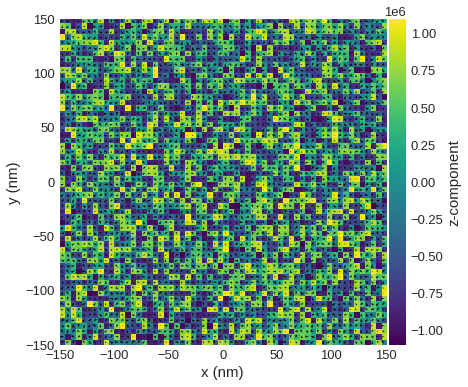

In [2]:
system.m.sel("z").mpl()

Relax the system and plot its magnetisation.

Running OOMMF (ExeOOMMFRunner)[2023/01/17 18:09]... (5.7 s)


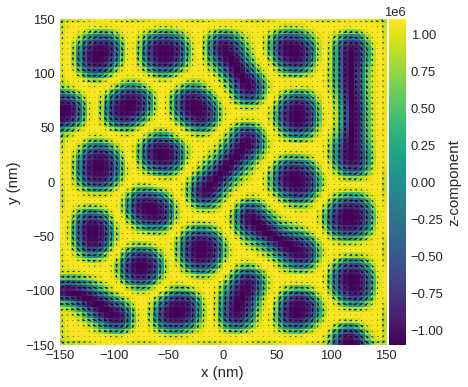

In [3]:
# NBVAL_IGNORE_OUTPUT
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.sel("z").mpl()

From the magnetisation, we can compute the MOKE related quantities.

## Computing MOKE

Calculation of the magneto-optical Kerr effect is based off an
incident wave $E^i$ described by
\begin{equation}
E^i = 
\begin{pmatrix}
   E^i_s \\ E^i_p
\end{pmatrix},
\end{equation}
where $E^i_s$ and $E^i_p$ are the electric field components of incident linear
s and p polarisation modes.

i.e. 
\begin{equation}
E^i = 
\begin{pmatrix}
   1 \\ 0
\end{pmatrix},
\end{equation}
is s polarised,

\begin{equation}
E^i = 
\begin{pmatrix}
   0 \\ 1
\end{pmatrix},
\end{equation}
is p polarised,

and 
\begin{equation}
E^i = 
\begin{pmatrix}
   1 \\ 1j
\end{pmatrix},
\end{equation}
is circularly polarised.

The reflected wave can be obtained by multiplication by the reflection matrix
\begin{equation}
    \begin{pmatrix} E^r_s \\ E^r_p \end{pmatrix} =
    \begin{pmatrix} r_{ss} & r_{sp} \\ r_{ps} & r_{pp} \end{pmatrix}
    \begin{pmatrix} E^i_s \\ E^i_p \end{pmatrix}
\end{equation}.
Similarly, the transmitted wave can be obtained by multiplication by the reflection matrix
\begin{equation}
    \begin{pmatrix} E^r_s \\ E^r_p \end{pmatrix} =
    \begin{pmatrix} t_{ss} & t_{sp} \\ t_{ps} & t_{pp} \end{pmatrix}
    \begin{pmatrix} E^i_s \\ E^i_p \end{pmatrix}
\end{equation}.

These matrices can be obtained from the 4-by-4 product matrix $M$ which can be descried as four 2-by-2 matrices using
\begin{align}
    M &= \begin{pmatrix} G & H \\ I & J \end{pmatrix}, \\
    G^{-1} &= \begin{pmatrix} t_{ss} & t_{sp} \\ t_{ps} & t_{pp} \end{pmatrix},\\
    I^{-1} &= \begin{pmatrix} r_{ss} & r_{sp} \\ r_{ps} & r_{pp} \end{pmatrix}.
\end{align}

The product matrix $M$ is calculated based of the the system being studied by dividing the system up into layers of magnetisation in the $z$ direction.
Each of these layers have a thickness and boundaries, in order to describe this we can use the boundary matrix of the $j$th layer $A_j$ and the propagation matrix of the layer $D_{j}$.
This leads to a description of a single layer as $A_j D_j A^{-1}_j$.
$A_{j}$ and $D_{j}$ are both 4-by-4 matrices.

If we assume are material is surrounded by free space, the whole system can thus be described by the product matrix $M$ withe the following form
\begin{equation}
    M = A_f^{-1} \prod_{j} A_{j} D_j A_j^{-1} A_f,
\end{equation}
where $A_j$ is the boundary matrix for the $j$th layer,
$D_j$ is the propagation matrix for the $j$th layer,
and $A_f$ is the boundary layer matrix for free space.

The boundary matrix can be written as
\begin{equation}
    A_{j} =
    \begin{pmatrix}
    1 & 0 & 1 & 0 \\
    \frac{iQ\alpha^2_{yi}}{2} \left(m_y \frac{1+\alpha^2_{zi}}
    {\alpha_{yi}\alpha_{zi}} - m_z\right) & \alpha_{zi} &
    -\frac{iQ\alpha^2_{yi}}{2} \left(m_y \frac{1+\alpha^2_{zi}}
    {\alpha_{yi}\alpha_{zi}} + m_z\right) & -\alpha_{zi} \\
    -\frac{in_jQ}{2} \left(m_y \alpha_{yi} + m_z \alpha_{zi} \right) &
    -n_j &
    -\frac{in_jQ}{2} \left(m_y \alpha_{yi} - m_z \alpha_{zi} \right) &
    -n_j \\
    n_j\alpha_{zj} & -\frac{in_jQ}{2} \left(m_y \frac{\alpha_{yi}}
    {\alpha_{zi}} - m_z \right) & -n_j \alpha_{zj} &
    \frac{in_jQ}{2} \left(m_y \frac{\alpha_{yi}}
    {\alpha_{zi}} + m_z \right)
    \end{pmatrix}
\end{equation}
where $\alpha_{yi}=\sin\theta_j, \alpha_{zi}=\cos\theta_j$,
$\theta_j$ is the complex refractive angle, $Q$ is the Voight
parameter and $n_j$ is the refractive index of the $j$th layer.
The angle is measure with respect to the $z$ axis and is calculated
using Snell's law.
$m_x$, $m_y$ and
$m_z$ are the normalized magnetisation.

The propagation matrix can be written as
\begin{equation}
    D_{j} =
    \begin{pmatrix}
    U\cos\delta^i & U\sin\delta^i & 0 & 0 \\
    -U\sin\delta^i & U\cos\delta^i & 0 & 0 \\
    0 & 0 & U^{-1}\cos\delta^r & U^{-1}\sin\delta^r \\
    0 & 0 & -U^{-1}\sin\delta^r & U^{-1}\cos\delta^r
    \end{pmatrix}
\end{equation}

where

\begin{align}
    U &= \exp\left(\frac{-i2\pi n_j \alpha_{zj} d_j}{\lambda} \right)\\
    \delta^i &= -\frac{\pi n_j Q d_j g^i}{\lambda \alpha_{zj}} \\
    \delta^r &= -\frac{\pi n_j Q d_j g^r}{\lambda \alpha_{zj}} \\
    g^i &= m_z \alpha_{zj} + m_y \alpha_{yj} \\
    g^r &= m_z \alpha_{zj} - m_y \alpha_{yj}
\end{align}

where $\alpha_{yi}=\sin\theta_j, \alpha_{zi}=\cos\theta_j$,
$\theta_j$ is the complex refractive angle, $Q$ is the Voight
parameter, $n_j$ is the refractive index, and $d_j$
is the thickness of the $j$th layer.
The angle is measure with respect to the $z$ axis and is calculated
using Snell's law.
$m_x$, $m_y$ and
$m_z$ are the normalized magnetisation.
$\lambda$ is the wavelength of light.

*Please be aware that the current version of MOKE is still under development and does not deal with the refractive index correctly*

The function `mag2exp.moke.e_field` is used to calculate the relected or transmitted electric field based on an incident field `E_i`.

In [4]:
import mag2exp

In [5]:
E_i = [1, 0]

theta = 0
n_0 = 2
Q = 1
wavelength = 600e-9  # Meters
E_r = mag2exp.moke.e_field(system.m, theta, n_0, Q, wavelength, E_i, mode="reflection")

/home/sam/repos/ubermag-devtools/repos/mag2exp/mag2exp/moke.py:504: UserWarning: This technique is currently under development so results may not be accurate. Please see the documentation for further details.
  warnings.warn(


The reflected field is `discretisedfield` objects with components `s` and `p` for each of the linear polarisations. These can be accessed using

In [6]:
E_r.s

Field(Mesh(Region(pmin=[-1.5e-07, -1.5e-07], pmax=[1.5e-07, 1.5e-07], dims=['x', 'y'], units=['m', 'm']), n=[60, 60]), nvdim=1)

The intensity of the MOKE image is 
\begin{equation}
I_K = \lvert E^r_s \rvert ^2 + \lvert E^r_p \rvert ^2.
\end{equation}
The function `mag2exp.moke.intensity` can be used to calculate this quantity.

In [7]:
intensity = mag2exp.moke.intensity(
    system.m, theta, n_0, Q, wavelength, E_i, mode="reflection"
)

/home/sam/repos/ubermag-devtools/repos/mag2exp/mag2exp/moke.py:504: UserWarning: This technique is currently under development so results may not be accurate. Please see the documentation for further details.
  warnings.warn(


As the `intensity` is a `discretisedfield` object, the built in plotting functions can be used to view it.

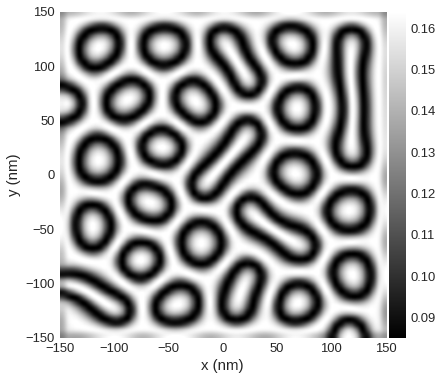

In [8]:
intensity.mpl.scalar(interpolation="spline16", cmap="gray")

Similarly the transmitted intensity can be calculated.

/home/sam/repos/ubermag-devtools/repos/mag2exp/mag2exp/moke.py:504: UserWarning: This technique is currently under development so results may not be accurate. Please see the documentation for further details.
  warnings.warn(


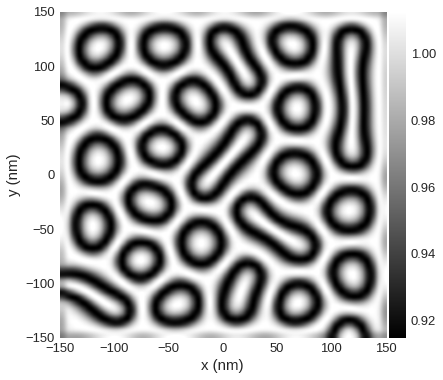

In [9]:
intensity = mag2exp.moke.intensity(
    system.m, theta, n_0, Q, wavelength, E_i, mode="transmission"
)
intensity.mpl.scalar(interpolation="spline16", cmap="gray")

This can also be done for circularly polarised light.

/home/sam/repos/ubermag-devtools/repos/mag2exp/mag2exp/moke.py:504: UserWarning: This technique is currently under development so results may not be accurate. Please see the documentation for further details.
  warnings.warn(


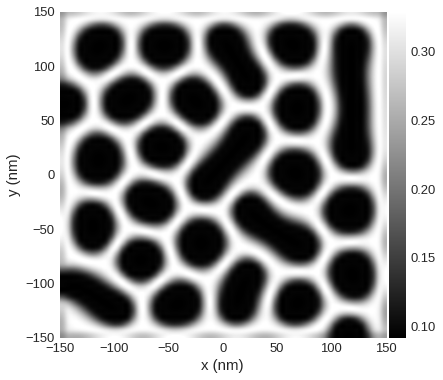

In [10]:
E_i = [1, 1j]
intensity = mag2exp.moke.intensity(
    system.m, theta, n_0, Q, wavelength, E_i, mode="reflection"
)
intensity.mpl.scalar(interpolation="spline16", cmap="gray")

Incident at an angle

/home/sam/repos/ubermag-devtools/repos/mag2exp/mag2exp/moke.py:504: UserWarning: This technique is currently under development so results may not be accurate. Please see the documentation for further details.
  warnings.warn(


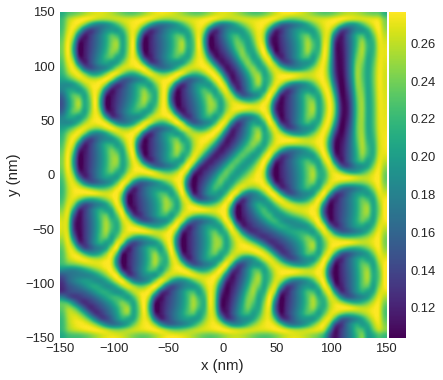

In [11]:
theta = np.pi / 4
intensity = mag2exp.moke.intensity(
    system.m, theta, n_0, Q, wavelength, E_i, mode="reflection"
)
intensity.mpl.scalar(interpolation="spline16")

The Kerr angle of the reflected light can be obtained using 
\begin{align}
    \Phi_s &= \phi_s' + i \phi_s'' \\
    &= \frac{r_{ps}}{r_{ss}} \\
    \Phi_p &= \phi_p' + i \phi_p'' \\
    &= -\text{Real}\left(\frac{r_{sp}}{r_{pp}}\right) + \text{Imag}\left(\frac{r_{sp}}{r_{pp}}\right) i
\end{align}
where $\phi'$ is the Kerr rotation and
$\phi''$ is the ellipticity for the s and p polarisations.

The function `mag2exp.moke.kerr_angle` enables the rotation and ellipticity to be obtained.

In [12]:
theta = 0
kerr_angle = mag2exp.moke.kerr_angle(system.m, theta, n_0, Q, wavelength)

/home/sam/repos/ubermag-devtools/repos/mag2exp/mag2exp/moke.py:384: UserWarning: This technique is currently under development so results may not be accurate. Please see the documentation for further details.
  warnings.warn(


The s polarisation Kerr rotation

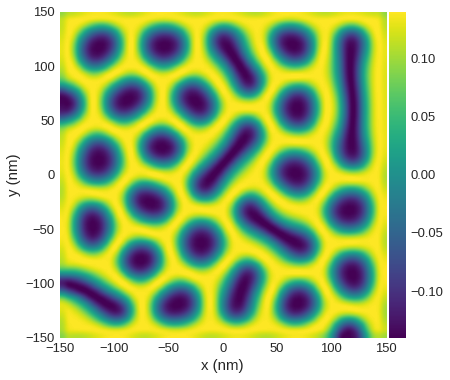

In [13]:
kerr_angle.s.real.mpl.scalar(interpolation="spline16")

The s polarisation ellipticity

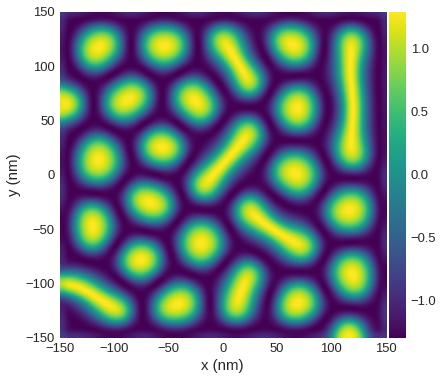

In [14]:
kerr_angle.s.imag.mpl.scalar(interpolation="spline16")

The p polarisation Kerr rotation

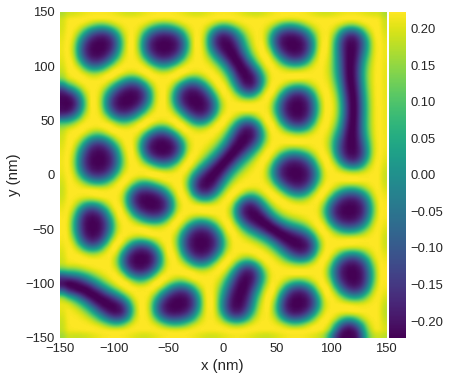

In [15]:
kerr_angle.p.real.mpl.scalar(interpolation="spline16")

The p polarisation ellipticity

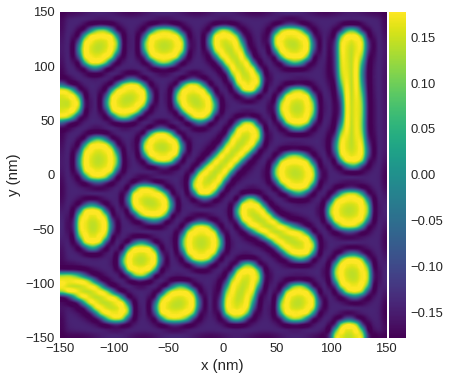

In [16]:
kerr_angle.p.imag.mpl.scalar(interpolation="spline16")

Often experiments can be limited by their resolution. In order to take this into account when computing images the `kerr_angle`, `e_field`, and `intensity` functions has the ability to convolute the output with a 2-dimensional Gaussian to view different spatial resolutions. A value for the Full Width Half Maximum (FWHM) of the Gaussian can be specified (in meters) for each dimension. For example a convolution of a 2 dimensional Gaussian with the intensity image is shown below.

/home/sam/repos/ubermag-devtools/repos/mag2exp/mag2exp/moke.py:504: UserWarning: This technique is currently under development so results may not be accurate. Please see the documentation for further details.
  warnings.warn(


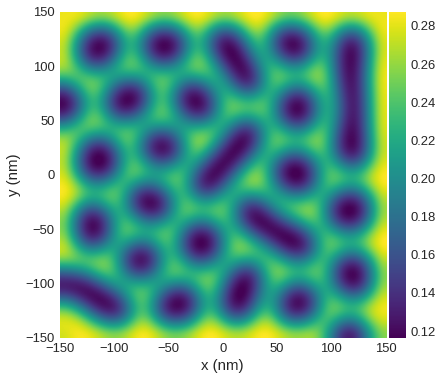

In [17]:
intensity = mag2exp.moke.intensity(
    system.m, theta, n_0, Q, wavelength, E_i, mode="reflection", fwhm=(25e-9, 25e-9)
)
intensity.mpl.scalar(interpolation="spline16")